# Travaux pratiques du cours d'introduction aux problèmes inverses en génie civil



## Exemple du compacteur

Après avoir vu la vidéo sur le processus du compactage, vous comprenez l'intérêt d'un capteur logiciel du contact bille-matériau construit à partir des mesures du couple fourni par le moteur. Cet signal comprend les informations sur le contact et des informations sur le modèle dynamique du compacteur.



Vous êtes un(e) doctorant(e) intelligent(e), pleins d'avenir. On vous demande de déterminer le modèle dynamique du compateur. 
Les équations du modèle direct sont
$$ \ddot{q} = \frac{\Gamma - rF}{zz} $$
$$ \gamma =  \frac{F-F_{frot}}{m} $$
$$ F_{frot} = f_v v + f_s sign(v)$$


 $\gamma$ est l'accélération du centre de gravité. $v$ est la vitesse du compacteur. $r$ est le rayon des billes.  $\ddot{q}$ est l'accélération articulaire des deux billes du compacteur. $\Gamma$ est le couple délivré par le moteur hydraulique et réparti sur les deux billes. Les paramètres inconnus sont :
* $m$, la masse  du compacteur.
* $f_v$, le frottement visqueux
* $f_s$, le frottement sec
* $zz$ la somme de l'inertie de la bille avant et celle de la bille arrière




Il vous est fourni :

* $\Gamma$ le couple mesuré (appelé couple_mesuré dans le code python)

* $q$ la position articulaire (appelé q)

* $r$ le rayon des roues (appelé r)

échantilllonné à 100 Hz (T=0,01s) sur une trajectoire usuelle du compacteur.

A partir de ces informations, trouver $m$, $f_v$, $f_s$, $zz$

* Notre dragon : le compacteur.

* Les empreintes : les mesures de couples et de position


In [2]:
import numpy as np
from experiences import experience1
couple_mesure, q, T, r = experience1()


Facile !

    Construisons le problème inverse : comment s'écrit la force en fonction des positions, vitesses et accélération et des paramètres. 

$\Gamma = \left(r\gamma \ rv \ r \  \ddot{q} \right)\cdot \left( \begin{array}{c} m \\ f_v \\ f_s \\ zz \end{array} \right) + b$

$b$ est un bruit. 

Le problème est sous la forme
$$ Y =W \cdot X + b$$

si le bruit est normal $b  \leadsto \mathcal{N}(0, \sigma)$, l'estimateur sans biais de variance minimale est l'estimateur des moindres carrés :
 $$ \hat{X}_{mc} = \arg \min_{X} \| Y - WX \|^2$$ 

$$ \hat{X}_{mc}= (W^tW)^{-1}W^tY$$

$$Var(X)= \sigma (W^tW)^{-1} $$

Il faut calculer W et donc, $v$, $\gamma$. Nous utilisons
$$ v = r\dot{q}$$
$$ \gamma=r\ddot{q}$$
$$ F=\Gamma/r$$

Pour calculer $\dot{q}$ et $\ddot{q}$, nous faisons une différence finie centrée autant de fois que  nécessaire en suivant le schéma numérique suivant.

$$ dx(n) =  \frac{x(n+1)-x(n-1)}{2T}$$

$dx(n)$ est la dérivée numérique de $x(n)$.

In [3]:
# calcul des vitesses et accélération 
dq=(q[2:]-q[:-2])/(2*T)
ddq=(dq[2:]-dq[:-2])/(2*T)

# tous les signaux sont mis à la même taille
dq=dq[1:-1]
couple_mesure = couple_mesure[2:-2]

In [4]:
# calcul de W et Y
W = np.transpose([r*r*ddq, r*r*dq,r*np.ones(np.size(dq)), ddq])
Y=np.transpose(couple_mesure)
#

In [5]:
# résolution par moindres carrés
# nous utilisons la librairie linalg
X=np.linalg.lstsq(W,Y)[0]

In [7]:
print('La masse du compacteur est {:.10f} kg'.format(
      X[0]))
print('Le frottement visqueux {:.10f} kg/s'.format(
      X[1]))
print('Le frottement sec est {:.10f} N'.format(
      X[2]))
print('L'' inertie des billes est  {:.10f} kg.m2'.format(
      X[3]))


La masse du compacteur est -0.0049125533 kg
Le frottement visqueux 0.4298494075 kg/s
Le frottement sec est 1054.8659057801 N
L inertie des billes est  -0.0107820100 kg.m2


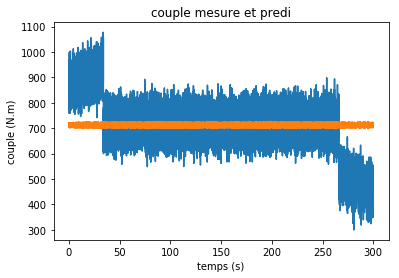

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline 
couple_predit=np.transpose(W.dot(X))

nech=np.size(Y)
temps=T*np.arange(1,nech+1)
plt.figure(1)
plt.plot(temps, couple_mesure, temps, couple_predit)
plt.title('couple mesure et predi')
plt.xlabel('temps (s)')
plt.ylabel('couple (N.m)')

<img src="dragon_colere.png" />

Vous avis commis de multiples erreurs que nous pouvons classer en trois catégories (selon Nicholas Taieb, les cygnes noirs) :
  * erreur de narration (mind projection fallacy)
  * erreur ludique 
  * erreur de confirmation


référence : "Le cygne noir : La puissance de l'imprévisible" - Nassim Nicholas Taleb 

In [10]:
np.save('W',W)

import pickle
f = open("moindres_carres", 'wb')
pickle.dump([W, Y, ddq, dq, q, couple_mesure,T,r], f)
f.close()